In [2]:
import pandas as pd
import numpy as np
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt


import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

In [3]:
figsize = (7.5, 6)

In [4]:
# Load data

data_dir = 'data/Champaign/'
dfb = pd.read_csv(data_dir + 'business.csv', encoding='latin-1')
dfr = pd.read_csv(data_dir + 'review.csv', encoding='latin-1')
dfu = pd.read_csv(data_dir + 'user.csv', encoding='latin-1')
datar = pd.read_csv(data_dir + 'data_review.csv', encoding='latin-1')

In [5]:
print(datar.shape)
datar.head()

(24088, 3)


,user_id,business_id,stars
0,94431,56,2
1,397042,56,1
2,259145,56,3
3,412466,56,1
4,84515,57,4


In [6]:
# Split the dataset into a training set a test set

X_train, X_test, y_train, y_test = train_test_split(datar[['user_id', 'business_id']].values, datar['stars'].values, \
                                                   test_size=0.5, random_state=30)

In [7]:
def norm_cm(cm):
    cm = deepcopy(cm).astype(float)
    for i in range(len(cm)):
        cm[i, :] = cm[i, :] / np.sum(cm[i, :])
    return cm  

def plot_cm(cm, title='', file_name=None):
    
    # Reference:
    # https://github.com/kevin11h/YelpDatasetChallengeDataScienceAndMachineLearningUCSD
    
    cm = norm_cm(cm)
    c = plt.pcolor(cm, edgecolors='k', linewidths=4, cmap='jet', vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Actual target label')
    plt.xlabel('Predicted target label')
    plt.xticks(0.5 + np.arange(5), np.arange(1,6))
    plt.yticks(0.5 + np.arange(5), np.arange(1,6))
    
    def show_values(pc, fmt="%.2f", **kw):
        pc.update_scalarmappable()
        for p, value in zip(pc.get_paths(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if value >= 0.3:
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            plt.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)
    
    show_values(c)
    
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')


### Baseline model 1: estimating biases with sample averages

In [8]:
class BaselineMean(BaseEstimator):
    def __init__(self):
        self.fitted = False
    
    def _fit_id2index(self, X):
        self._user_id_array = np.unique(X[:, 0])
        self._user_id_dict = {self._user_id_array[i]:i for i in range(len(self._user_id_array))}
        self._bus_id_array = np.unique(X[:, 1])
        self._bus_id_dict = {self._bus_id_array[i]:i for i in range(len(self._bus_id_array))}
        return self
        
    def _transform_id2index(self, X):
        X = deepcopy(X)
        X[:, 0] = np.array([self._user_id_dict.get(x, -1) for x in X[:, 0]])
        X[:, 1] = np.array([self._bus_id_dict.get(x, -1) for x in X[:, 1]])
        return X
    
    def _fit_transform_id2index(self, X):
        self._fit_id2index(X)
        X = self._transform_id2index(X)
        return X
    
    def fit(self, X, y):
        X = self._fit_transform_id2index(X)
        self.mean_global = np.mean(y)
        df = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1))
        self.mean_user_bias = df[[0, 2]].groupby(0, as_index=False).mean().sort_values(by=0)[2].values - self.mean_global
        self.mean_bus_bias = df[[1, 2]].groupby(1, as_index=False).mean().sort_values(by=1)[2].values - self.mean_global
        self.fitted = True
        return self
    
    def _predict_no_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_user_bias[x_i[0]] + self.mean_bus_bias[x_i[1]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
    
    def _predict_user_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_bus_bias[x_i[1]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
    
    def _predict_bus_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_user_bias[x_i[0]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
        
    def _predict_all_missing(self, X):
        if len(X) == 0:
            return np.array([])
        return self.mean_global * np.ones(len(X))
    
    def _predict_regression(self, X):
        X = self._transform_id2index(X)
        y_pred = np.zeros(len(X))
        no_missing = np.logical_and(X[:, 0] != -1, X[:, 1] != -1)
        user_missing = np.logical_and(X[:, 0] == -1, X[:, 1] != -1)
        bus_missing = np.logical_and(X[:, 0] != -1, X[:, 1] == -1)
        all_missing = np.logical_and(X[:, 0] == -1, X[:, 1] == -1)
        y_pred[no_missing] = self._predict_no_missing(X[no_missing])
        y_pred[user_missing] = self._predict_user_missing(X[user_missing])
        y_pred[bus_missing] = self._predict_bus_missing(X[bus_missing])
        y_pred[all_missing] = self._predict_all_missing(X[all_missing])
        return y_pred
    
    def _predict_classification(self, X):
        y = self._predict_regression(X)
        y = np.round(y)
        y[y < 1] = 1
        y[y > 5] = 5
        return y.astype(int)
    
    def predict(self, X, classification=False):
        if not self.fitted:
            raise ValueError('Estimator not fitted.')
        if not classification:
            return self._predict_regression(X)
        else:
            return self._predict_classification(X)
    
    def score(self, X, y, classification=False):
        if not classification:
            return r2_score(y, self.predict(X, classification))
        else:
            return accuracy_score(y, self.predict(X, classification))

In [9]:
bm = BaselineMean().fit(X_train, y_train)
model_name = 'Sample average baseline model'
print(model_name + ':')
print('R2 score on training set: {}.'.format(bm.score(X_train, y_train)))
print('R2 score on test set: {}.'.format(bm.score(X_test, y_test)))

Sample average baseline model:
R2 score on training set: 0.5533846228155628.
R2 score on test set: -0.02307790642455121.


$R^2$ score on the test set is much lower than that on the training set, indicating overfitting occurs.

We can also interpret the prediction of this recommender system as a classification problem by rounding the predicted values to closest labels. We can calculate the classification accuracy and plot the confusion matrix.

Sample average baseline model:
Classification accuracy on training set: 0.5686648953835934.
Classification accuracy on test set: 0.31991032879442044.


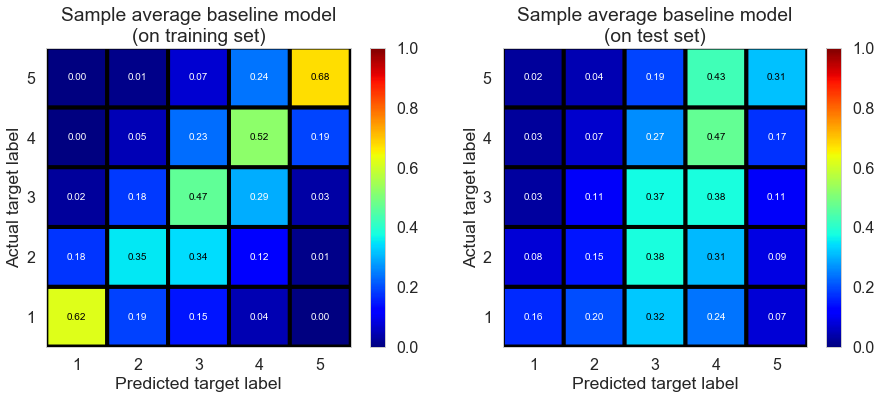

In [10]:
print(model_name + ':')
print('Classification accuracy on training set: {}.'.format(bm.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(bm.score(X_test, y_test, classification=True)))

y_pred_train_label = bm.predict(X_train, classification=True)
y_pred_test_label = bm.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), model_name + '\n(on training set)')
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), model_name + '\n(on test set)')

### Baseline model 2: estimating biases using regularized regression

In [13]:
class BaselineRegression(BaselineMean):
    def __init__(self):
        super().__init__()
        
    def fit(self, X, y):
        X = self._fit_transform_id2index(X)
        self.mean_global = np.mean(y)
        y = y - self.mean_global
        